# Challenge Notebook

The Fish Market dataset contains measurements of fish species commonly found in markets, with features such as Weight, Height, Width, and multiple Length attributes. It includes both continuous variables (like weight and dimensions) and a categorical target variable, Species, representing different types of fish. This dataset allows for exploration of relationships between physical characteristics and the species, making it suitable for regression and classification tasks. The goal is to understand patterns in the data and predict the weight based on the fish's attributes.

## Imports and Setup

In [177]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
df = pd.read_csv("data2.csv")


df.sample(10)

,Species,Weight,Length1,Length2,Length3,Height,Width
126,Perch,1000.0,40.2,43.5,46.0,12.6040,8.1420
55,Whitefish,270.0,23.6,26.0,28.7,8.3804,4.2476
71,Parkki,300.0,24.0,26.0,29.0,11.3680,4.2340
34,Bream,950.0,38.0,41.0,46.5,17.6235,6.3705
151,Smelt,10.0,11.3,11.8,13.1,2.2139,1.2838
14,Bream,600.0,29.4,32.0,37.2,14.9544,5.1708
116,Perch,900.0,36.5,39.0,41.4,11.1366,7.4934
56,Whitefish,270.0,24.1,26.5,29.3,8.1454,4.2485
111,Perch,840.0,32.5,35.0,37.3,11.4884,7.7957
12,Bream,500.0,29.1,31.5,36.4,13.7592,4.3680


## Exploratory Data Analysis (EDA)

In [178]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [179]:
missing_values = df.isnull().sum()
print(missing_values)

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


No missing data found

In [180]:
zero_counts = (df == 0).sum()
print(zero_counts)


df = df[(df != 0).all(axis=1)]


Species    0
Weight     1
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


In [181]:
zero_counts = (df == 0).sum()
print(zero_counts)

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64


Cleaning out 0 valued weight, since it is likely to be an inertion error

## First impression plots

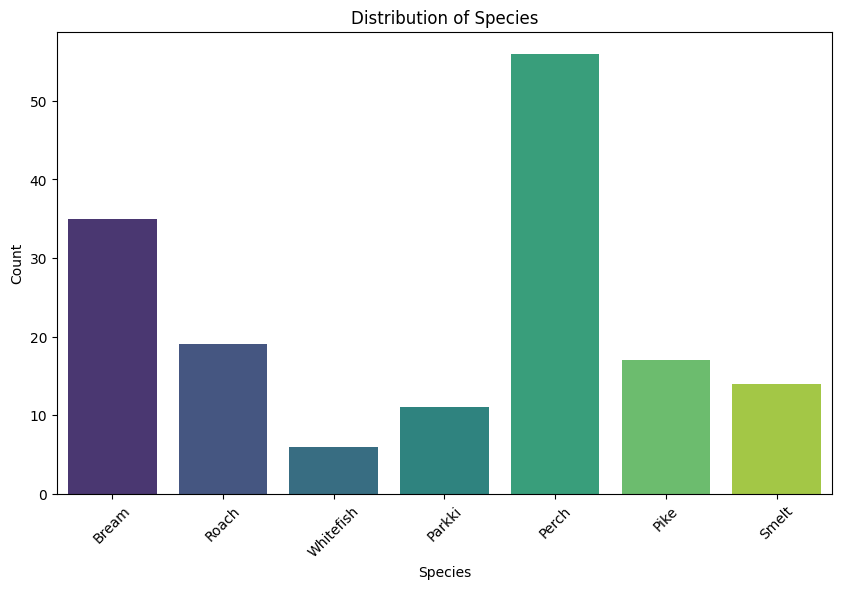

In [182]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Species', hue='Species', palette='viridis', legend=False)
plt.title("Distribution of Species")
plt.xlabel("Species")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()




the Perch species appears to be the most represented in the dataset, while the Whitefish is the least frequent, indicating a class imbalance that may need to be considered during modeling.

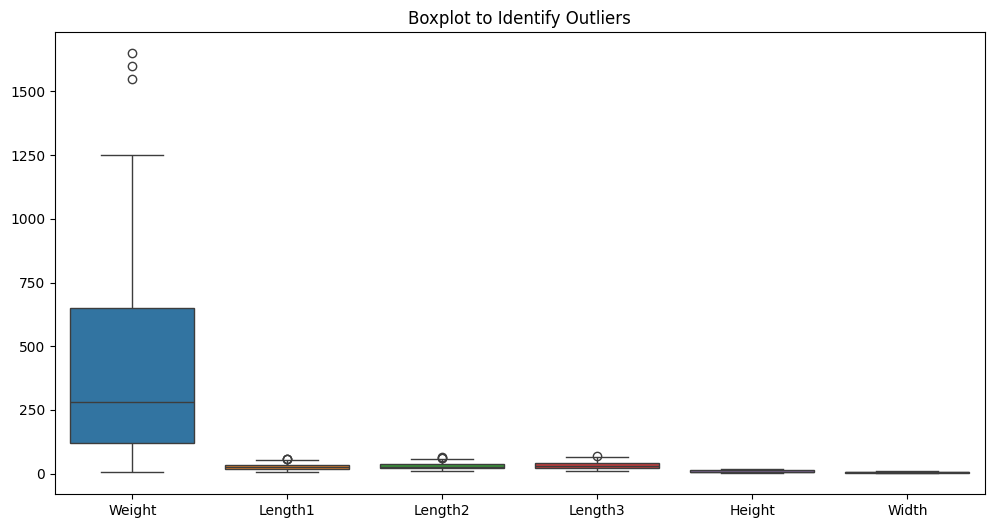

In [183]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.select_dtypes(include=['float64']))
plt.title("Boxplot to Identify Outliers")
plt.show()


The boxplot reveals significant outliers in the 'Weight' feature, with values extending far beyond the upper quartile. These outliers appear to be genuine observations rather than errors, as they follow the expected biological pattern where larger fish have disproportionately greater weight compared to length dimensions.

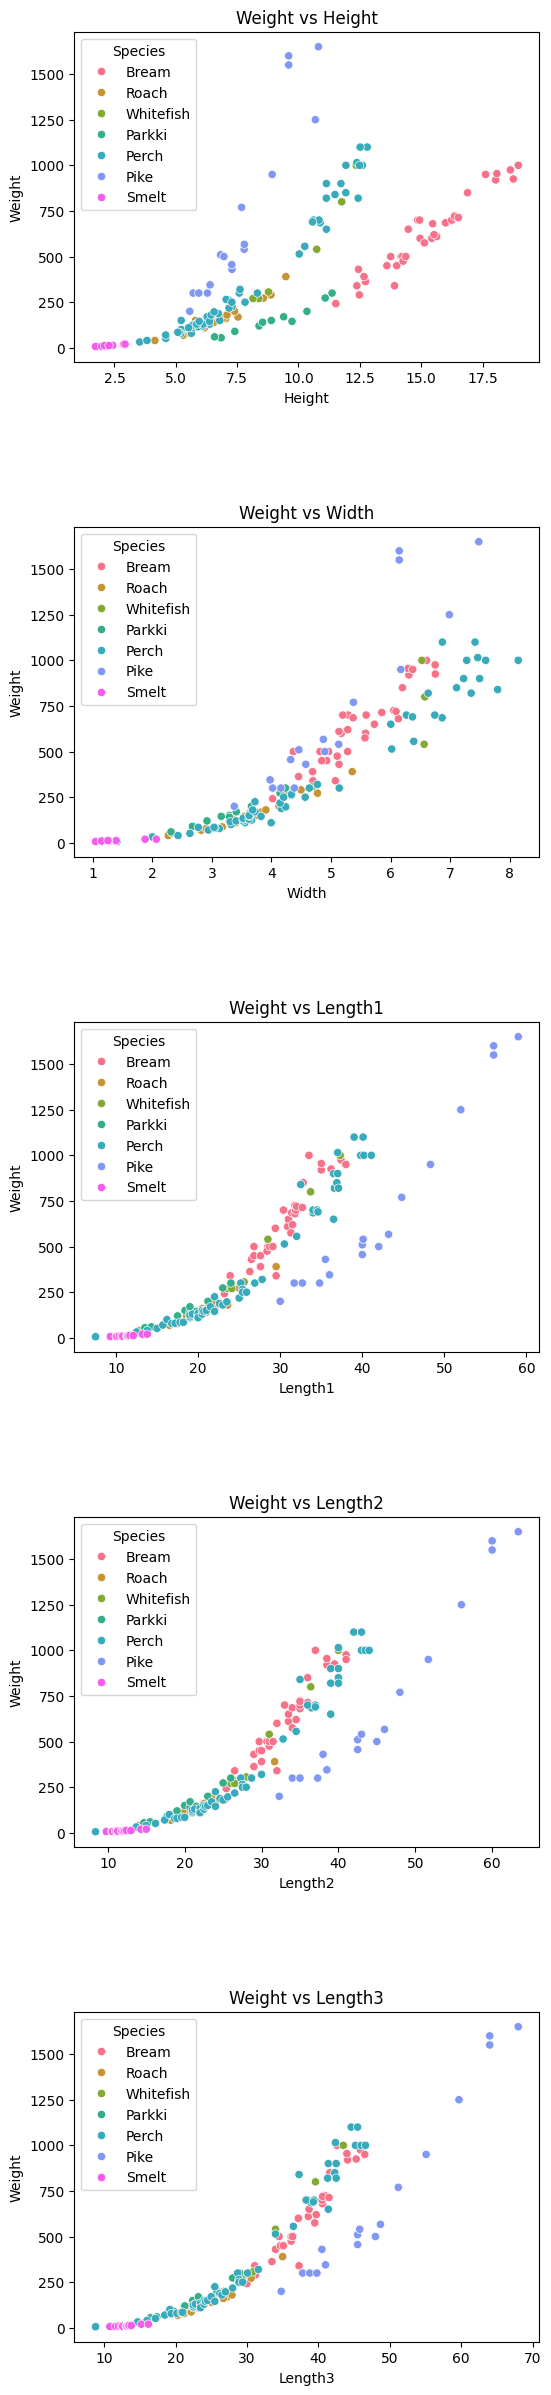

In [184]:
features = ['Height', 'Width', 'Length1', 'Length2', 'Length3']

fig, axes = plt.subplots(len(features), 1, figsize=(6, 6 * len(features)))


for i, feature in enumerate(features):
    sns.scatterplot(data=df, x=feature, y='Weight', hue='Species', palette='husl', ax=axes[i])
    axes[i].set_title(f"Weight vs {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Weight')


plt.subplots_adjust(hspace=0.5)

plt.show()

The plots reveal a positive correlation between the dimensions of the fish (height, width, and various lengths) and its weight. While the relationship is generally positive, it does not appear to follow a strictly linear pattern, suggesting a more complex or non-linear interaction between these variables

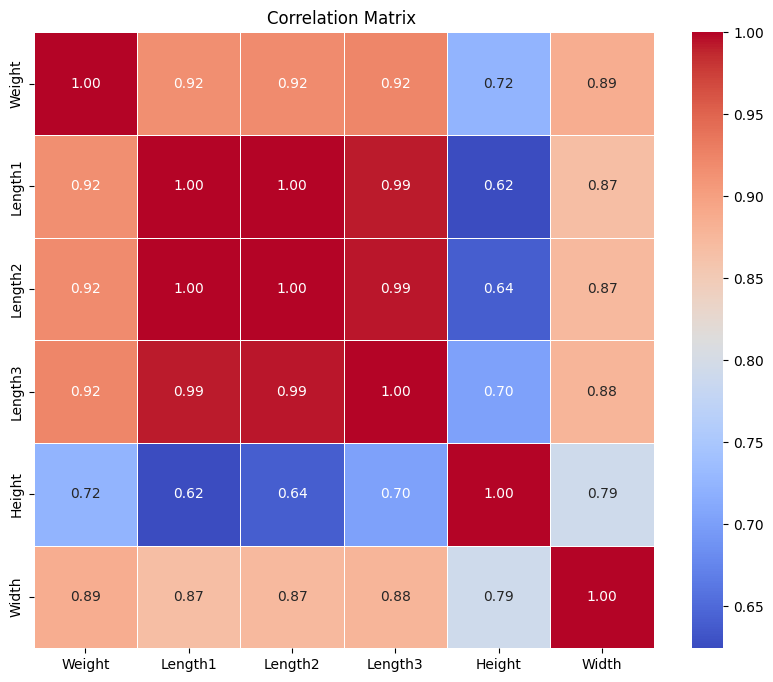

In [185]:
df_numeric = df.select_dtypes(include='number')
plt.figure(figsize=(10, 8))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix ")
plt.show()

In [186]:

lengths = df_numeric[['Length1', 'Length2', 'Length3']]
cov_matrix = lengths.cov()
eigenvalues = np.linalg.eigvals(cov_matrix)

print("Eigenvalues for the lengths:", eigenvalues)


Eigenvalues for the lengths: [3.49424081e+02 3.46958378e-02 1.14063071e+00]


In [187]:
print(correlation_matrix['Weight'].sort_values(ascending=False))


Weight     1.000000
Length3    0.923090
Length2    0.918603
Length1    0.915719
Width      0.886654
Height     0.723857
Name: Weight, dtype: float64


There appears to be multicollinearity among the three length measurements (Length1, Length2, and Length3). This is evident from both their high pairwise correlations and the eigenvalues of their correlation matrix: [348.4, 0.0345, 1.133]. The presence of a very small eigenvalue (~0.03) indicates that at least one of these features contributes very little unique information and is likely a linear combination of the others.

To reduce redundancy and simplify the model without losing essential information, we will retain only Length3, as it best represents the overall length of the fish.

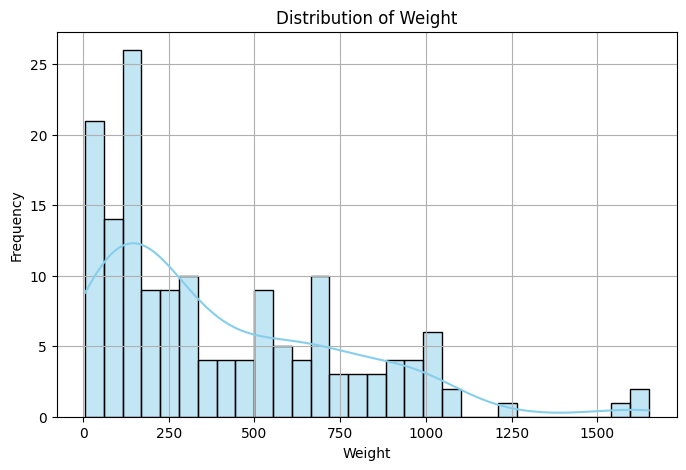

In [188]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Weight'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Most of the fish weights are concentrated on the lower end of the scale, with a long tail extending to the right, indicating a smaller number of fish with significantly higher weights. This right-skewed distribution is also confirmed by the KDE curve, which peaks early and gradually tapers off. To address this skewness and improve model performance, a transformation (square root) of the weight variable is necessary.

In [189]:
import scipy.stats as stats

grouped_length3 = [df[df['Species'] == species]['Length3'] for species in df['Species'].unique()]
f_statistic_length3, p_value_length3 = stats.f_oneway(*grouped_length3)
print(f"ANOVA for Length3 - p-value: {p_value_length3}")
if p_value_length3 < 0.05:
    print("There is a significant difference between the species with respect to Length3.")
else:
    print("There is no significant difference between the species with respect to Length3.")


grouped_height = [df[df['Species'] == species]['Height'] for species in df['Species'].unique()]
f_statistic_height, p_value_height = stats.f_oneway(*grouped_height)
print(f"ANOVA for Height - p-value: {p_value_height}")
if p_value_height < 0.05:
    print("There is a significant difference between the species with respect to Height.")
else:
    print("There is no significant difference between the species with respect to Height.")

grouped_width = [df[df['Species'] == species]['Width'] for species in df['Species'].unique()]
f_statistic_width, p_value_width = stats.f_oneway(*grouped_width)
print(f"ANOVA for Width - p-value: {p_value_width}")
if p_value_width < 0.05:
    print("There is a significant difference between the species with respect to Width.")
else:
    print("There is no significant difference between the species with respect to Width.")



ANOVA for Length3 - p-value: 4.8519284485761594e-30
There is a significant difference between the species with respect to Length3.
ANOVA for Height - p-value: 8.665687062808403e-44
There is a significant difference between the species with respect to Height.
ANOVA for Width - p-value: 2.630799782380991e-19
There is a significant difference between the species with respect to Width.


To incorporate the difference in the features across species into the model, we can create ratios feature

In [190]:
Fishmarket = df
mean_lengths = Fishmarket.groupby('Species')['Length3'].mean()
mean_height = Fishmarket.groupby('Species')['Height'].mean()
mean_width = Fishmarket.groupby('Species')['Width'].mean()
Fishmarket['Length3_to_mean_ratio'] = Fishmarket.apply(lambda row: row['Length3'] / mean_lengths[row['Species']], axis=1)
Fishmarket['Height_to_mean_ratio'] = Fishmarket.apply(lambda row: row['Height'] / mean_height[row['Species']], axis=1)
Fishmarket['Width_to_mean_ratio'] = Fishmarket.apply(lambda row: row['Width'] / mean_width[row['Species']], axis=1)

In [191]:

Fishmarket.drop(columns=['Length1', 'Length2'], inplace=True)
Fishmarket.sample(10)

,Species,Weight,Length3,Height,Width,Length3_to_mean_ratio,Height_to_mean_ratio,Width_to_mean_ratio
42,Roach,120.0,23.7,6.1146,3.2943,0.944817,0.911762,0.896660
26,Bream,720.0,40.6,16.3618,6.0900,1.058552,1.077624,1.122040
142,Pike,1600.0,64.0,9.6000,6.1440,1.313692,1.244528,1.207931
2,Bream,340.0,31.1,12.3778,4.6961,0.810861,0.815229,0.865224
98,Perch,188.0,26.2,6.7334,4.1658,0.885990,0.856463,0.877801
129,Pike,300.0,37.8,5.7078,4.1580,0.775900,0.739949,0.817477
45,Roach,160.0,25.3,7.0334,3.8203,1.008603,1.048767,1.039829
71,Parkki,300.0,29.0,11.3680,4.2340,1.272437,1.268406,1.314606
80,Perch,85.0,20.8,5.1376,3.0368,0.703382,0.653483,0.639902
83,Perch,115.0,22.5,5.9175,3.3075,0.760870,0.752684,0.696943


## Model Building

In [192]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np


features = ['Length3', 'Height', 'Width', 'Length3_to_mean_ratio',"Height_to_mean_ratio",'Width_to_mean_ratio']
X = df[features]
y = df['Weight']

y_sqrt = np.sqrt(y)


X_train, X_test, y_train, y_test = train_test_split(X, y_sqrt, test_size=0.2, random_state=42)


model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)


r2 = r2_score(y_test, y_pred)


print("Square Root Transformed Target")
print(f"R²: {r2:.4f}")


Square Root Transformed Target
R²: 0.9894


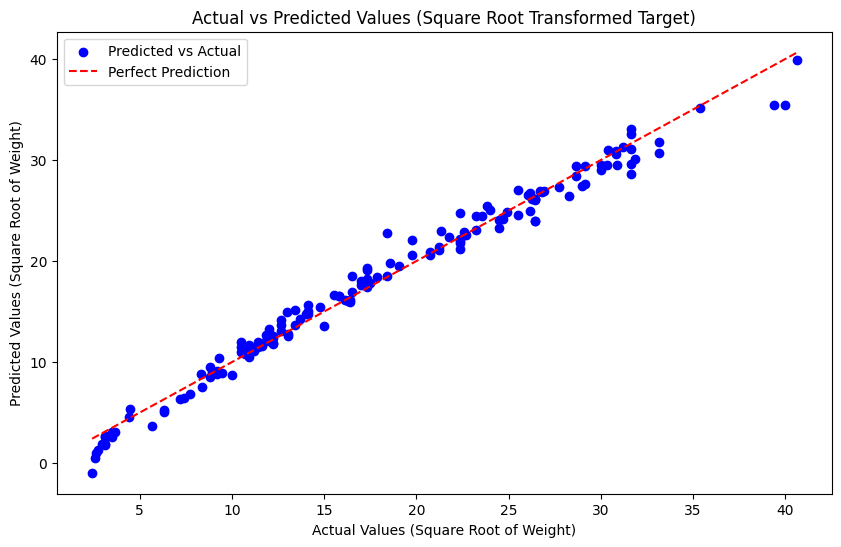

In [193]:

y_pred = model.predict(X)


plt.figure(figsize=(10, 6))
plt.scatter(y_sqrt, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_sqrt), max(y_sqrt)], [min(y_sqrt), max(y_sqrt)], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values (Square Root Transformed Target)')
plt.xlabel('Actual Values (Square Root of Weight)')
plt.ylabel('Predicted Values (Square Root of Weight)')
plt.legend()
plt.show()


In [194]:

feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(model.coef_)
}).sort_values(by='Importance', ascending=False)

print(feature_importance)



                 Feature  Importance
3  Length3_to_mean_ratio    3.621645
5    Width_to_mean_ratio    2.989448
2                  Width    1.981906
4   Height_to_mean_ratio    1.914448
0                Length3    0.402080
1                 Height    0.270439


In [195]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


ridge_model = Ridge(alpha=1.0)


ridge_model.fit(X_train, y_train)


y_pred_ridge = ridge_model.predict(X_test)


r2_ridge = r2_score(y_test, y_pred_ridge)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print("Ridge Regression Model")
print(f"R²: {r2_ridge:.4f}")
print(f"MSE: {mse_ridge:.4f}")

Ridge Regression Model
R²: 0.9878
MSE: 1.1050


In [196]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

elastic_net_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)


elastic_net_model.fit(X_train, y_train)


y_pred_elastic = elastic_net_model.predict(X_test)

r2_elastic = r2_score(y_test, y_pred_elastic)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)

print("Elastic Net Regression Model")
print(f"R²: {r2_elastic:.4f}")
print(f"MSE: {mse_elastic:.4f}")



Elastic Net Regression Model
R²: 0.9818
MSE: 1.6527


In [197]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)

xgb_model.fit(X_train, y_train)


y_pred_xgb = xgb_model.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print("XGBoost Regressor Model")
print(f"R²: {r2_xgb:.4f}")
print(f"MSE: {mse_xgb:.4f}")



XGBoost Regressor Model
R²: 0.9823
MSE: 1.6058


In [198]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


svr_model = SVR(kernel='linear')

svr_model.fit(X_train, y_train)


y_pred_svr = svr_model.predict(X_test)


r2_svr = r2_score(y_test, y_pred_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)

print("SVR with Linear Kernel")
print(f"R²: {r2_svr:.4f}")
print(f"MSE: {mse_svr:.4f}")

SVR with Linear Kernel
R²: 0.9849
MSE: 1.3717



## Results and Conclusion

After exploring various regression models to predict fish weight based on physical measurements, we've found that the Linear Regression model with square root transformation of the target variable performed best, achieving an R² score of 0.9894 on the test set. This high score indicates that the model can explain approximately 98.94% of the variance in fish weight using the selected features.

Key findings from our analysis:

1. The square root transformation effectively addressed the right-skewed distribution of the weight variable, enabling more accurate predictions.

2. The species-specific ratio features we engineered provided additional predictive power by capturing how individual fish compare to the typical measurements for their species.

3. The strong correlation between the three length measurements allowed us to simplify the model by using only Length3 without sacrificing performance.

4. While more complex models like XGBoost were tested, the linear regression model provided the best balance of performance, interpretability, and simplicity. This suggests that the relationship between fish dimensions and weight, when appropriately transformed, can be well-approximated by a linear function.

These findings have practical applications in fish markets, where accurately estimating fish weight from easily measurable dimensions can streamline operations. Additionally, for marine biologists, this model offers insights into the dimensional relationships that determine fish weight across different species.
